In [111]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as  nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
import time
from tqdm.autonotebook import tqdm, trange
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'


#######################Тут не все компании!!!######################################
#######################Тут не все компании!!!######################################
companies = ['SBER','GAZP' , 'LKOH', 'GMKN', 'MGNT',
       'TATN', 'NVTK', 'SNGS', 'PLZL', 'SNGSP',
       'PIKK', 'ROSN', 'SBERP', 'CHMF', 'NLMK',
       'IRAO', 'YNDX', 'ALRS', 'RUAL', 'MTSS',
       'MAGN', 'PHOR', 'RTKM', 'VTBR', 'TATNP',
       'TCSG', 'AGRO', 'AFLT', 'AFKS',
       'TRNFP', 'CBOM',
       'FIVE', 'MOEX',
       'HYDR']
companies = ['SBER', 'SBERP', 'VTBR', 'TATNP','TRNFP', 'MOEX']
######################Тут не все компании!!!##############################################
######################Тут не все компании!!!##############################################

In [2]:
path = '~/Рабочий стол/ДИПЛОМ НОУТБУКИ/DL forcasitng diplom/Данные Мосбиржа/Total_MOEX_hourly_with_time_df'
total_df = pd.read_csv(path)

In [112]:
# total_df.tradetime = total_df.close
# total_df.drop(['close', 'pr_close'], 1, inplace = True)
# total_df.rename(columns={'tradetime':'close'}, inplace=True)
# total_df = total_df.set_index('tradedate')

In [266]:
l = []
for i in companies:
    data = total_df[total_df['secid'] == i]
    l.append(data.shape[0])

max_len = min(l)
data = np.zeros((max_len, len(companies)))
for i, company in enumerate(companies):
    series = np.array(total_df[total_df.secid == company].close)[:max_len]
    data[:,i] += series

In [267]:

train_data = data[ : round(data.shape[0]*0.80) ]
val_data = data[ round(data.shape[0]*0.80) : ]


# train_data = data[ : round(data.shape[0]*0.55) ]
# val_data = data[ round(data.shape[0]*0.60) : ]

In [268]:
for i in range(data.shape[1]):
    if i == 0:
        train_series = train_data[:,i].reshape(-1, 1)
        val_series = val_data[:,i].reshape(-1, 1)
    
        scaler_star = StandardScaler()
        train_series = scaler_star.fit_transform(train_series)
        val_series = scaler_star.transform(val_series)
    
        train_data[:, i] = train_series.flatten()
        val_data[:, i] = val_series.flatten()
    
    elif i != 0:
        train_series = train_data[:,i].reshape(-1, 1)
        val_series = val_data[:,i].reshape(-1, 1)
        
        scaler = StandardScaler()
        train_series = scaler.fit_transform(train_series)
        val_series = scaler.transform(val_series)
        
        train_data[:, i] = train_series.flatten()
        val_data[:, i] = val_series.flatten()

In [214]:
train_data1 = train_data[ : round(data.shape[0]*0.53) ]
train_data2 = train_data[ round(data.shape[0]*0.60) : round(data.shape[0]*0.80) ]

In [215]:
def sample_creator(df, lookback, horizon):
    """
    Функция нарезает данные скользящим окном, 
    lookback=исторический промежуток
    horizon=горизонт прогнозирования
    !Внимание! target переменная должна стоять в первом столбце!
    """
    X = []
    Y = np.array([np.zeros(horizon) for i in range(lookback, df.shape[0]-horizon+1 )])
    
    for i in range(lookback, df.shape[0]-horizon+1):
        x = df[i-lookback : i, :]
        X.append(x)
        y = df[i:i+horizon, 0]
        Y[i-lookback] += y
        
        
    X = torch.Tensor(np.array(X))
    Y = torch.Tensor(Y)
    return X, Y

In [236]:
# lookback = 52
# horizon = 1

# x_train, y_train = sample_creator(data_train, lookback, horizon)
# x_val, y_val = sample_creator(data_val, lookback, horizon)

# print(f'x_train: {x_train.shape}, y_train: {y_train.shape}\nx_val: {x_val.shape}, y_val: {y_val.shape}')


lookback = 32
horizon = 1

x_train1, y_train1 = sample_creator(train_data1, lookback, horizon)
x_train2, y_train2 = sample_creator(train_data2, lookback, horizon)
x_val, y_val = sample_creator(val_data, lookback, horizon)

x_train= torch.Tensor( np.concatenate([x_train1, x_train2]) )
y_train = torch.Tensor( np.concatenate([y_train1, y_train2]) )

train_dataset = TensorDataset(x_train, y_train)
val_dataset  = TensorDataset(x_val, y_val)                          


train_loader = DataLoader(train_dataset, batch_size=150, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=150, shuffle=False)

print(f'x_train: {x_train.shape}, y_train: {y_train.shape}\nx_val: {x_val.shape}, y_val: {y_val.shape}')

x_train: torch.Size([5710, 32, 6]), y_train: torch.Size([5710, 1])
x_val: torch.Size([1550, 32, 6]), y_val: torch.Size([1550, 1])


In [125]:
# train_dataset = TensorDataset(x_train, y_train)
# val_dataset  = TensorDataset(x_val, y_val)

# train_loader = DataLoader(train_dataset, batch_size=150, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=150, shuffle=False)

In [227]:
def winrate(y_true, y_pred):
    '''
    Входной формат: BatchSize*horizon(1)
    Выводит усреднённое число угаданных направлений по всему горизонту прогнозирования
    и всем батчам.
    Если горизонт = 1, то просто усредняет по батчам 
    '''
    
    diff_pred_vec = np.sign(np.diff(y_pred))
    diff_true_vec = np.sign(np.diff(y_true))
    res = np.where( diff_true_vec == diff_pred_vec , 1, 0).sum() / diff_true_vec.size
    return res

In [228]:
import TSMixer.TSMixer_models as mix
print(mix.TSMixer.__doc__)


    seq_len = длина последовательности, на которую смотрит модель для прогноза
    num_features = количество признаков
    forecast_horizon = горизонт прогнозирвания
    dropout = коэффициент дропаута
    num_of_blocks = количество Mixer блоков в архитектуре
    


In [237]:
model = mix.TSMixer(lookback, len(companies), horizon, 0.1, 1).to(device)

In [238]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3, verbose=True)

epochs = 150
early_stop_count = 0
min_val_loss = float('inf')

train_loss_per_epoch = []
val_loss_per_epoch = []
train_winrate = []
val_winrate = []



pbar = trange(epochs, desc="Epoch:")
since = time.time()

for epoch in pbar:
    model.train()
    train_losses = 0
    train_win = 0
    for batch in tqdm(train_loader, leave=False, desc="Train iter:"):
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        train_losses += loss.item()
        optimizer.step()
        train_loss = train_losses/len(train_loader)
        train_win += winrate(y_batch.reshape(-1,).cpu().detach(), outputs.reshape(-1,).cpu().detach())
    train_loss_per_epoch.append(train_loss)    
    train_winrate.append(train_win / len(train_loader))
    
    # Validation
    model.eval()
    val_losses = 0
    val_win = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, leave=False, desc="Val iter:"):
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses += loss.item()
            val_win += winrate(y_batch.reshape(-1,).cpu().detach(), outputs.reshape(-1,).cpu().detach())
    val_loss = val_losses/len(val_loader)
    val_loss_per_epoch.append(val_loss)
    val_winrate.append(val_win / len(val_loader))
    
    scheduler.step(val_loss)
    if val_loss < 0.0007:
        torch.save(model.state_dict(), f'ВЕСА/(4blocks)(6as)TSMixer(M F=AS) 1D|W={val_win / len(val_loader)}, VL={val_loss}' )
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 15:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}","/",f"{epochs},Train Loss: {train_loss:.6f} Validation Loss: {val_loss:.6f}")
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    

Epoch::   0%|          | 0/150 [00:00<?, ?it/s]

Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1 / 150,Train Loss: 0.158381 Validation Loss: 0.018743


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2 / 150,Train Loss: 0.029359 Validation Loss: 0.018348


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3 / 150,Train Loss: 0.023502 Validation Loss: 0.014963


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4 / 150,Train Loss: 0.020813 Validation Loss: 0.014745


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5 / 150,Train Loss: 0.016043 Validation Loss: 0.009263


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6 / 150,Train Loss: 0.014667 Validation Loss: 0.007177


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7 / 150,Train Loss: 0.011713 Validation Loss: 0.005782


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8 / 150,Train Loss: 0.009825 Validation Loss: 0.005066


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9 / 150,Train Loss: 0.008719 Validation Loss: 0.004282


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10 / 150,Train Loss: 0.007375 Validation Loss: 0.003937


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11 / 150,Train Loss: 0.006620 Validation Loss: 0.003959


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12 / 150,Train Loss: 0.005840 Validation Loss: 0.003026


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13 / 150,Train Loss: 0.005299 Validation Loss: 0.003104


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14 / 150,Train Loss: 0.004724 Validation Loss: 0.002684


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15 / 150,Train Loss: 0.004247 Validation Loss: 0.002472


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 16 / 150,Train Loss: 0.004005 Validation Loss: 0.002194


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 17 / 150,Train Loss: 0.003617 Validation Loss: 0.001982


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 18 / 150,Train Loss: 0.003297 Validation Loss: 0.001966


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 19 / 150,Train Loss: 0.003056 Validation Loss: 0.001682


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 20 / 150,Train Loss: 0.002819 Validation Loss: 0.001611


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 21 / 150,Train Loss: 0.002596 Validation Loss: 0.001604


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 22 / 150,Train Loss: 0.002303 Validation Loss: 0.001594


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 23 / 150,Train Loss: 0.002135 Validation Loss: 0.001309


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 24 / 150,Train Loss: 0.002132 Validation Loss: 0.001058


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 25 / 150,Train Loss: 0.002060 Validation Loss: 0.001105


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 26 / 150,Train Loss: 0.001914 Validation Loss: 0.001076


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 27 / 150,Train Loss: 0.001765 Validation Loss: 0.001039


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 28 / 150,Train Loss: 0.001731 Validation Loss: 0.000945


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 29 / 150,Train Loss: 0.001598 Validation Loss: 0.000883


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 30 / 150,Train Loss: 0.001595 Validation Loss: 0.000959


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 31 / 150,Train Loss: 0.001651 Validation Loss: 0.000797


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 32 / 150,Train Loss: 0.001520 Validation Loss: 0.001007


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 33 / 150,Train Loss: 0.001515 Validation Loss: 0.000711


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 34 / 150,Train Loss: 0.001450 Validation Loss: 0.000949


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 35 / 150,Train Loss: 0.001393 Validation Loss: 0.000748


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 36 / 150,Train Loss: 0.001331 Validation Loss: 0.000865


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00037: reducing learning rate of group 0 to 2.0000e-04.
Epoch 37 / 150,Train Loss: 0.001286 Validation Loss: 0.000762


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 38 / 150,Train Loss: 0.001262 Validation Loss: 0.000735


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 39 / 150,Train Loss: 0.001251 Validation Loss: 0.000774


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 40 / 150,Train Loss: 0.001276 Validation Loss: 0.000746


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00041: reducing learning rate of group 0 to 4.0000e-05.
Epoch 41 / 150,Train Loss: 0.001280 Validation Loss: 0.000727


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 42 / 150,Train Loss: 0.001235 Validation Loss: 0.000749


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 43 / 150,Train Loss: 0.001297 Validation Loss: 0.000719


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 44 / 150,Train Loss: 0.001236 Validation Loss: 0.000749


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00045: reducing learning rate of group 0 to 8.0000e-06.
Epoch 45 / 150,Train Loss: 0.001225 Validation Loss: 0.000740


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 46 / 150,Train Loss: 0.001237 Validation Loss: 0.000713


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 47 / 150,Train Loss: 0.001244 Validation Loss: 0.000728


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Early stopping!
Training complete in 0m 6s


In [79]:
# model = TSMixer(lookback, len(companies), 1, 0.0, 3).to(device)
# model.load_state_dict(torch.load('ВЕСА/(4blocks)(6as)TSMixer(M F=AS) 1D|W=0.46802806355855053, VL=0.0007030559833462272[\'SBER\', \'SBERP\', \'VTBR\', \'TATNP\',\'TRNFP\', \'MOEX\']'))

In [244]:
# Evaluation
model.eval()
predictions1 = []
with torch.no_grad():
    for batch in val_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions1.extend(outputs.squeeze().tolist())
predictions1 = np.array(predictions1)

In [245]:
winrate(y_val.reshape(-1,), predictions1)

0.4977404777275662

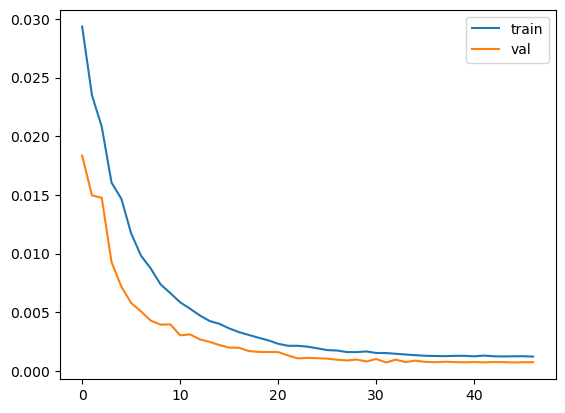

In [246]:
plt.plot(train_loss_per_epoch[1:])
plt.plot(val_loss_per_epoch[1:])
plt.legend(['train','val'])

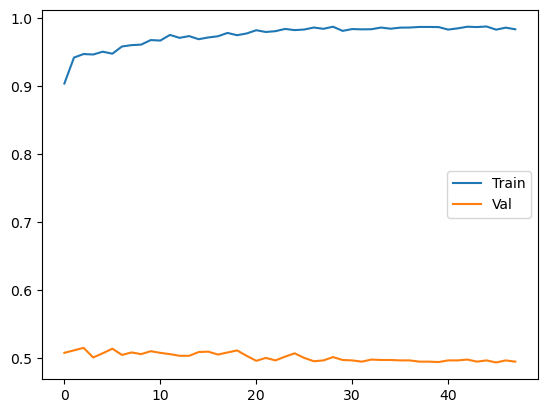

In [247]:
plt.plot(train_winrate)
plt.plot(val_winrate)
plt.legend(['Train','Val'])

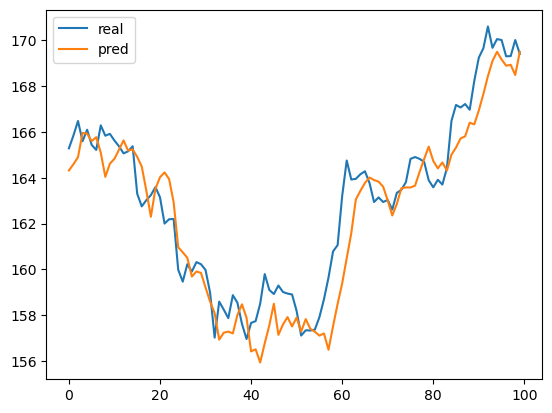

In [274]:
plt.plot(y_val[:100])
plt.plot(predictions1[:100])
plt.legend(['real','pred'])

In [271]:
predictions1 = scaler_star.inverse_transform(predictions1.reshape(-1,1))

In [270]:
y_val = scaler_star.inverse_transform(y_val)

In [273]:
criterion(torch.Tensor(predictions1),torch.Tensor(y_val)).item()

4.049796104431152

In [201]:
train_loader = DataLoader(train_dataset, batch_size=150, shuffle=False)

model.eval()
predictions2 = []
with torch.no_grad():
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions2.extend(outputs.squeeze().tolist())
predictions2 = np.array(predictions2)

In [202]:
winrate(y_train.reshape(-1,), predictions2)

0.4813452443510247

In [204]:
y_train = scaler_star.inverse_transform(y_train)

In [206]:
predictions2 = scaler_star.inverse_transform(predictions2.reshape(-1,1))

In [207]:
criterion(torch.Tensor(y_train), torch.Tensor(predictions2))

tensor(2.5909)

In [239]:
torch.save(model.state_dict(), f'ЧВЕСА/[32,6,1,0.1,1]TSMixer(M F=AS) 1D|W=0.4861, TL=1.7683 VL=2.1109' )